# Collaboration recommender system 1.0 (Homogeneous)

## **Setting up environment**

---



### **Package installation**

Installing `torch` and `torch_geometric` libraries.

In [1]:
import torch
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.4.0+cpu


### **Loading libraries**

In [4]:
# PyTorch imports
from torch import Tensor
import torch.nn.functional as F

# PyTorch Geometric imports
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.lightgcn import BPRLoss
from torch_geometric.data import Data
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.metrics import (
    LinkPredPrecision,
    LinkPredRecall,
    LinkPredMAP,
    LinkPredMRR,
    LinkPredNDCG
)

# Other imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from box import Box
from util.postgres import create_connection, query

In [3]:
device = 'cpu'

print(torch.__version__)
print(torch_geometric.__version__)
print(f"Device: '{device}'")

2.4.0+cpu
2.7.0
Device: 'cpu'


### **Global variables**

In [5]:
# Initiate global variables

num_recommendations = 10  # Number of recommendations
num_train = 0.8  # Percentage of data used for training
learning_rate = 1e-2  # Learning rate
num_epochs = 100  # Number of epochs
hidden_channels = 64  # Number of hidden channels
config = Box.from_yaml(filename="../../config.yaml")
connection = create_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.BQ_SCHEMA
)

## **Data preparation**

---



### **Loading data**

When loading the data, we take into account only the articles, where at least one author comes from the EUTOPIA

In [6]:
# Get all authors data and value metrics about their collaboration
author_query = f"""
SELECT author_sid,
       publication_count,
       embedding_tensor_data
FROM lojze.bigquery_legacy.graph_homogeneous_node_author
"""
author_df = query(conn=connection, query_str=author_query)

C:\Development\eutopia-collaboration-recommender\ecr-recommender\util\postgres.py:127: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [7]:
# Get all edges between authors and co-authors
coauthored_query = f"""
SELECT author_sid,
       co_author_sid,
       time
FROM lojze.bigquery_legacy.graph_homogeneous_edge_co_authors
"""
coauthored_df = query(conn=connection, query_str=coauthored_query)

### Contiguous unique identifier for node: **author**

In [8]:
# Author: Map each unique MD5 hash to a contiguous unique integer ID
unique_authors = author_df['author_sid'].unique()
author_id_map = {author: i for i, author in enumerate(unique_authors)}
author_sid_map = {y: x for x, y in author_id_map.items()}
# ---> Adjust all dataframes
author_df['author_node_id'] = author_df['author_sid'].map(author_id_map)
coauthored_df['author_node_id'] = coauthored_df['author_sid'].map(author_id_map)
coauthored_df['co_author_node_id'] = coauthored_df['co_author_sid'].map(author_id_map)


## **Homogeneous graph creation**
First of all, we prepare the node features for articles. We first sort the article dataframe by node ID. We know that we have unique values in the article dataframe, i.e. one row per article and we can just sort it. Otherwise, we would need to create a unique mapping between article features and articles themselves. The sorting needs to match the node index that we will create later. After that, we also need to set up correct type (specifically, convert Pandas Int64 to int64, but we go for the lazy version and just convert all features to float64). At last, we exclude the `ARTICLE_SID` and `ARTICLE_NODE_ID` columns, because Torch can't work with strings.

**TODO:**
- Think about only including "valuable" partnerships/edges.

### Matrix X for node: **article**

In [11]:
# Article X
# Sort article dataframe
co_authors_edge_attr_columns = list(filter(lambda x: x not in (
    'author_sid', 'co_author_sid', 'author_node_id', 'co_author_node_id', 'embedding_tensor_data', 'time'),
                                           coauthored_df.columns))

# Convert types
edge_attr_co_authors = coauthored_df[co_authors_edge_attr_columns].astype('int64').values

### Matrix X for node: **author**

In [10]:
# Author X
# Sort author dataframe
sorted_author_df = author_df.sort_values(by='author_node_id')
# Exclude columns AUTHOR_SID, AUTHOR_NODE_ID
author_x_columns = list(
    filter(lambda x: x not in ('author_sid', 'author_node_id', 'embedding_tensor_data'), sorted_author_df.columns))

# Convert EMBEDDING_TENSOR_DATA to proper format
author_embedding_tensor = sorted_author_df['embedding_tensor_data'].apply(lambda x: np.array(x.replace('{', '').replace('}', '').split(',')).astype('float64'))
author_embedding_tensor = torch.tensor(author_embedding_tensor, dtype=torch.float)

# Convert types
author_x = sorted_author_df[author_x_columns].astype('float64').values

# Append embedding_tensor to author_x
author_x = np.concatenate((author_x, author_embedding_tensor), axis=1)

# Normalize X using std scaler
author_x = StandardScaler().fit_transform(author_x)


C:\Users\LukaŽontar\AppData\Local\Temp\ipykernel_35500\690007607.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  author_embedding_tensor = torch.tensor(author_embedding_tensor, dtype=torch.float)


### Edge index for edge: **(author, co_authors, author)**

In [12]:
# Add edge index: for edges corresponding to authors co-authoring articles (author to author connection)
author_node_ids = torch.from_numpy(coauthored_df['author_node_id'].values)
coauthor_node_ids = torch.from_numpy(coauthored_df['co_author_node_id'].values)
edge_index_co_authors = torch.stack([author_node_ids, coauthor_node_ids], dim=0)
edge_time_co_authors = torch.from_numpy(np.array(coauthored_df['time'].values.astype('int64')))
# edge_weight_co_authors = torch.from_numpy(np.array(coauthored_df['co_authorship_article_collaboration_novelty'].values.astype('int64')))

### Data object

After generating the initial node feature Numpy array, we create an instance of `HeteroData` class with two types of nodes corresponding to authors and articles and an edge denoting authors publishing articles.

*Note: We also need to make sure to add the reverse edges from authors to aritcles in order to let a GNN be able to pass messages in both directions. We can leverage the `T.ToUndirected()` transform for this from PyG.*

In [13]:
def split_to_train_and_test(data, num_train=0.8):
    time = data.edge_time
    perm = time.argsort()
    train_index = perm[:int(num_train * perm.numel())]
    test_index = perm[int(num_train * perm.numel()):]

    # Edge index
    data.train_pos_edge_index = data.edge_index[:, train_index]
    data.test_pos_edge_index = data.edge_index[:, test_index]

    # Add negative samples to test
    neg_edge_index_i, neg_edge_index_j, neg_edge_index_k = structured_negative_sampling(
        edge_index=data.test_pos_edge_index,
        num_nodes=data.num_nodes
    )
    data.test_neg_edge_index = torch.stack([neg_edge_index_i, neg_edge_index_k], dim=0)

    # data.edge_index = data.edge_attr = data.edge_time = None
    return data


def assert_bidirectional_edges(data):
    # Step 1: Transpose edge_index to get a list of edges
    edges = data.edge_index.t()  # Shape: [num_edges, 2]

    # Step 2: Create reverse edges by swapping columns
    reverse_edges = edges[:, [1, 0]]

    # Step 3: Check if all reverse edges exist in the original edge list
    # Convert edges to a set of tuples for faster lookup
    edges_set = set(map(tuple, edges.tolist()))

    # Iterate over reverse edges and check for their presence
    missing_edges = []
    for edge in reverse_edges.tolist():
        if tuple(edge) not in edges_set:
            missing_edges.append(edge)

    # If there are missing edges, raise an assertion error
    if missing_edges:
        raise AssertionError(f"The following edges are missing their reverse counterparts: {missing_edges}")

In [14]:
data = Data()

# Save node indices:
data.node_id = torch.arange(len(unique_authors))
# Add edge 'co_authors'
data.edge_index = edge_index_co_authors
data.edge_attr = torch.from_numpy(edge_attr_co_authors).to(torch.float)
data.edge_time = edge_time_co_authors

# Set X for author nodes
data.x = torch.from_numpy(author_x).to(torch.float)

# Metadata about number of features and nodes
data.num_features = data.x.shape[1]
data.num_nodes = data.x.shape[0]

# Transform data to undirected graph
# data = T.ToUndirected()(data)

# Split to train and test
data = split_to_train_and_test(data)

# Test: check that the number of elements in the positive edge index equals to the number of elements in the negative edge index
assert data.test_pos_edge_index.numel() == data.test_neg_edge_index.numel()
# Test: check that the number of elements in the training, positive edge index equals to 0.8 times all nodes
assert data.train_pos_edge_index.shape[1] == int(0.8 * data.edge_index.shape[1])
# Test: check that the number of elements in the test, positive edge index equals to 0.2 times all nodes
assert data.test_pos_edge_index.shape[1] == data.edge_index.shape[1] - int(0.8 * data.edge_index.shape[1])

# Test: check that all edges are bidirectional
# assert_bidirectional_edges(data)

# Print data
data

Data(node_id=[56233], edge_index=[2, 504538], edge_attr=[504538, 0], edge_time=[504538], x=[56233, 769], num_features=769, num_nodes=56233, train_pos_edge_index=[2, 403630], test_pos_edge_index=[2, 100908], test_neg_edge_index=[2, 100908])

## Model training


---



### Model definition

In [15]:
from typing import Optional, Union

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Embedding, ModuleList
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import is_sparse, to_edge_index
from torch_geometric.nn.models.lightgcn import BPRLoss


class CollaborationRecommender(torch.nn.Module):
    def __init__(self,
                 num_nodes: int,
                 input_channels: int,
                 hidden_channels: int,
                 k: int,
                 alpha: Optional[Union[float, Tensor]] = None):
        super().__init__()

        self.num_nodes = num_nodes
        self.hidden_channels = hidden_channels
        self.k = k

        # Initialize the convolutional layers
        self.conv_layers = ModuleList([
            GATv2Conv(in_channels=input_channels, out_channels=hidden_channels, add_self_loops=True,
                      negative_slope=0.2),
            GATv2Conv(in_channels=hidden_channels, out_channels=hidden_channels, add_self_loops=True,
                      negative_slope=0.2),
            GATv2Conv(in_channels=hidden_channels, out_channels=hidden_channels, add_self_loops=True,
                      negative_slope=0.2),
            GATv2Conv(in_channels=hidden_channels, out_channels=hidden_channels, add_self_loops=True,
                      negative_slope=0.2),
        ])

        # Initialize batch norm layers
        self.bn_layers = ModuleList([
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
        ])

        # Calculate the number of layers
        self.num_layers = len(self.conv_layers)
        # Initialize the alpha
        alpha = 1. / (self.num_layers + 1)
        alpha = torch.tensor([alpha] * (self.num_layers + 1))
        self.register_buffer('alpha', alpha)

        # Initialize the parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize the convolutional layers
        for conv in self.conv_layers:
            conv.reset_parameters()

    def get_embedding(self,
                      x: Tensor,
                      edge_index: Adj) -> Tensor:
        # Activate first layer, since it is not of the same size as the target embedding
        x = self.conv_layers[0](x, edge_index)
        x = self.bn_layers[0](x)
        # x = F.relu(x)
        out = x * self.alpha[0]
        print(self.alpha)

        # Activate all other layers
        for i in range(1, self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = self.bn_layers[i](x)
            # x = F.relu(x)
            out = out + x * self.alpha[i + 1]

        return out

    def forward(self,
                x: Tensor,
                edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        # Get the embedding
        out = self.get_embedding(x, edge_index)

        out_src = out[edge_label_index[0]]
        out_dst = out[edge_label_index[1]]

        # Calculate the dot product
        return (out_src * out_dst).sum(dim=-1)

    def recommend(self,
                  x: Tensor,
                  edge_index: Adj,
                  author_sid: str,
                  k: int = 10) -> Tensor:

        # Get all embeddings
        out_src = out_dst = self.get_embedding(x, edge_index)

        # Get the author id
        author_id = author_id_map[author_sid]
        # Get the author embedding
        out_src = out_src[author_id]

        # Calculate the dot product
        pred = out_src @ out_dst.t()
        # Get the top k recommendations
        top_index = pred.topk(k, dim=-1, sorted=True).indices

        # Decode top k recommendations to author SIDs
        top_author_sids = [author_sid_map[int(i)] for i in top_index]

        return top_author_sids

    def recommendation_loss(self,
                            x: Tensor,
                            edge_index: Adj,
                            pos_edge_rank: Tensor,
                            neg_edge_rank: Tensor,
                            node_id: Optional[Tensor] = None,
                            lambda_reg: float = 1e-4) -> Tensor:
        loss_fn = BPRLoss(lambda_reg)
        # Get the embedding
        emb = self.get_embedding(x=x, edge_index=edge_index)
        emb = emb if node_id is None else emb[node_id]
        return loss_fn(pos_edge_rank, neg_edge_rank, emb)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.hidden_channels}, num_layers={self.num_layers})')


model = CollaborationRecommender(num_nodes=data.num_nodes,
                                 input_channels=data.num_features,
                                 hidden_channels=hidden_channels,
                                 k=num_recommendations).to(device)

# Transfer to device
data = data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=10)

### Training helpers

In [16]:
import pytest
from torch_geometric.metrics.link_pred import LinkPredMetric


class LinkPredHitRate(LinkPredMetric):
    higher_is_better: bool = True

    def _compute(self, pred_isin_mat: Tensor, y_count: Tensor) -> Tensor:
        return pred_isin_mat.sum(dim=-1) >= 1


def test_hit_rate():
    pred_mat = torch.tensor([[1, 0], [1, 2], [0, 2], [0, 1]])
    edge_label_index = torch.tensor([[0, 0, 2, 2, 3], [0, 1, 2, 1, 2]])

    metric = LinkPredHitRate(k=2)
    metric.update(pred_mat, edge_label_index)
    result = metric.compute()

    assert result == pytest.approx((2) / 3)


test_hit_rate()


def train():
    model.train()

    pos_edge_index = data.train_pos_edge_index
    # Negative sampling
    neg_edge_index_i, neg_edge_index_j, neg_edge_index_k = structured_negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=data.num_nodes)
    neg_edge_index = torch.stack([neg_edge_index_i, neg_edge_index_k], dim=0)

    optimizer.zero_grad()

    # Concatenate edge label indices into a single edge label index
    edge_label_index = torch.cat([
        pos_edge_index,
        neg_edge_index,
    ], dim=1)

    pos_edge_rank, neg_edge_rank = model(x=data.x,
                                         edge_index=data.train_pos_edge_index,
                                         edge_label_index=edge_label_index).chunk(2)

    # Calculate BPR loss
    loss = model.recommendation_loss(x=data.x,
                                     edge_index=data.train_pos_edge_index,
                                     pos_edge_rank=pos_edge_rank,
                                     neg_edge_rank=neg_edge_rank,
                                     node_id=edge_label_index.unique())

    loss.backward()
    optimizer.step()

    total_loss = float(loss) * pos_edge_rank.numel()
    total_examples = pos_edge_rank.numel()

    # Cleanup
    del pos_edge_rank, neg_edge_rank
    torch.cuda.empty_cache()

    return total_loss / total_examples


@torch.no_grad()
def test():
    model.eval()

    pos_edge_index = data.test_pos_edge_index
    neg_edge_index = data.test_neg_edge_index

    edge_label_index = torch.cat([
        pos_edge_index,
        neg_edge_index,
    ], dim=1)

    # We encode the training edge index to get the embeddings based on the training graph
    # structure and then use those embeddings to predict unseen edges
    pos_edge_rank, neg_edge_rank = model(x=data.x,
                                         edge_index=data.train_pos_edge_index,
                                         edge_label_index=edge_label_index).chunk(2)

    # Calculate BPR loss
    loss = model.recommendation_loss(x=data.x,
                                     edge_index=data.train_pos_edge_index,
                                     pos_edge_rank=pos_edge_rank,
                                     neg_edge_rank=neg_edge_rank,
                                     node_id=edge_label_index.unique())

    total_loss = float(loss) * pos_edge_rank.numel()
    total_examples = pos_edge_rank.numel()

    # Cleanup
    del pos_edge_rank, neg_edge_rank
    torch.cuda.empty_cache()

    return total_loss / total_examples


@torch.no_grad()
def evaluate(k: int = 20):
    model.eval()
    embs = model.get_embedding(x=data.x, edge_index=data.train_pos_edge_index).to(device)

    result = {
        'precision@k': LinkPredPrecision(k=k).to(device),
        'recall@k': LinkPredRecall(k=k).to(device),
        'map@k': LinkPredMAP(k=k).to(device),
        'mrr@k': LinkPredMRR(k=k).to(device),
        'ndcg@k': LinkPredNDCG(k=k).to(device),
        'hit_rate@k': LinkPredHitRate(k=k).to(device)
    }

    # Calculate distance between embeddings
    logits = embs @ embs.T

    # Exclude training edges
    logits[data.train_pos_edge_index[0], data.train_pos_edge_index[1]] = float('-inf')

    # Gather ground truth data
    ground_truth = data.test_pos_edge_index

    # Get top-k recommendations for each node
    top_k_index = torch.topk(logits, k=k, dim=1).indices

    # Update performance metrics
    for metric in result.keys():
        result[metric].update(
            pred_index_mat=top_k_index,
            edge_label_index=ground_truth)

    # Cleanup
    del embs, logits, ground_truth, top_k_index
    torch.cuda.empty_cache()

    return result

### Training

In [17]:
import pandas as pd

results = []
for epoch in range(1,  num_epochs):
    train_loss = train()
    test_loss = test()
    scheduler.step(test_loss)
    eval_result = evaluate(k=num_recommendations)

    # Save results
    epoch_result = {
        'epoch': epoch  ,
        'train_loss_bpr': train_loss,
        'test_loss_bpr': test_loss,
        'precision@k': eval_result['precision@k'].compute(),
        'recall@k': eval_result['recall@k'].compute(),
        'map@k': eval_result['map@k'].compute(),
        'mrr@k': eval_result['mrr@k'].compute(),
        'ndcg@k': eval_result['ndcg@k'].compute(),
        'hit_rate@k': eval_result['hit_rate@k'].compute()
    }
    results.append(epoch_result)

    # Log results
    if epoch % 20 == 0:
        # Log model performance
        formatted_str = ', '.join([f'{key}: {epoch_result[key]:.4f}' for key in epoch_result.keys()])
        print(formatted_str)


results = pd.DataFrame(results)

ValueError: Expected 'edge_index' to be of integer type (got 'torch.float64')

In [1]:
data[model_config['target_edge_type']].train_edge_index

NameError: name 'data' is not defined

### Model evaluation

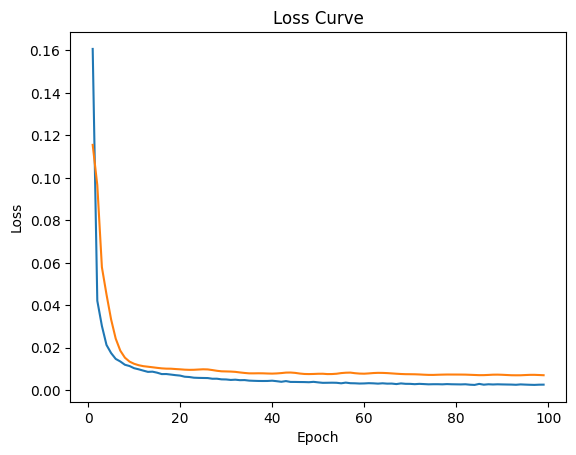

In [ ]:
# Generate loss curve
plt.plot(results['epoch'], results['train_loss_bpr'], label='train')
plt.plot(results['epoch'], results['test_loss_bpr'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

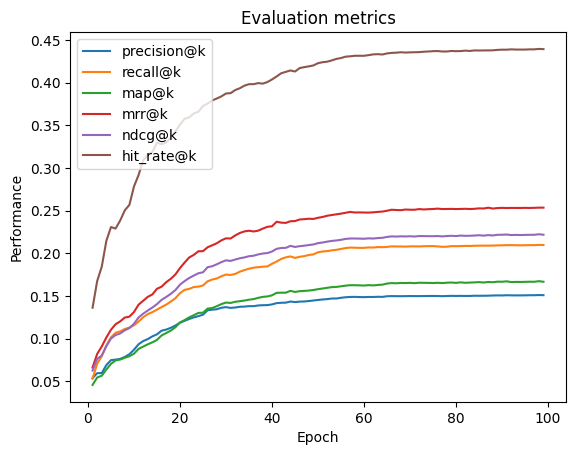

In [ ]:
# Generate evaluation metrics plot
plt.plot(results['epoch'], results['precision@k'], label='precision@k')
plt.plot(results['epoch'], results['recall@k'], label='recall@k')
plt.plot(results['epoch'], results['map@k'], label='map@k')
plt.plot(results['epoch'], results['mrr@k'], label='mrr@k')
plt.plot(results['epoch'], results['ndcg@k'], label='ndcg@k')
plt.plot(results['epoch'], results['hit_rate@k'], label='hit_rate@k')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Evaluation metrics')
plt.legend()
plt.show()

In [ ]:
author_sid = '170c9492a9a50fb8a99c45b8cbbf6f55'

model.recommend(x=data.x,
                edge_index=data.train_pos_edge_index,
                author_sid=author_sid,
                k=num_recommendations)

['920d813d1a50aa3585ee5e93ac420495',
 'a7319d2d988e523309c413b99bc74152',
 'e33b9ef60c86c57d5e2d0fff88c6aa2f',
 'd4614d4cc835e57af45f1996e2bd43b8',
 '56df1e8e02c012db4fbb480559c7f466',
 '56232105b46ba375b2f668a3dc9f935d',
 '46666f4f61a22789127054dfa10c541c',
 'cd8aba00c371592169bda05c8c74661e',
 'cf80a8ebc48308b53a9569c37290a048',
 'faa0b3dd567d4b98f5953d4f1632e92e']